In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

from collections import Counter

In [2]:
df = pd.read_csv("C:\\Users\\swastik\\Desktop\\PGPDS\\Machine Learning\\churn_prediction.csv")
df.shape

(28382, 21)

In [4]:
df['churn'].value_counts()

0    23122
1     5260
Name: churn, dtype: int64

## Data Preprocessing

In [5]:
df.isnull().sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
last_transaction                     0
dtype: int64

### `a) Missing Value Treatment`

In [6]:
#Convert Gender
dict_gender = {'Male': 1, 'Female':0}
df.replace({'gender': dict_gender}, inplace = True)

# Replace with -1 for missing gender
df['gender'] = df['gender'].fillna(-1)

# Replacing with max. occurence values
df['dependents'] = df['dependents'].fillna(0)
df['occupation'] = df['occupation'].fillna('self_employed')
df['city'] = df['city'].fillna(1020)

### `b) Dummy variables`

In [7]:
# Convert occupation to one hot encoded features
df = pd.concat([df,pd.get_dummies(df['occupation'],prefix = str('occupation'),prefix_sep='_')],axis = 1)

In [8]:
df.head()

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,current_balance,...,previous_month_debit,current_month_balance,previous_month_balance,churn,last_transaction,occupation_company,occupation_retired,occupation_salaried,occupation_self_employed,occupation_student
0,1,2101,66,1.0,0.0,self_employed,187.0,2,755,1458.71,...,0.20,1458.71,1458.71,0,2019-05-21,0,0,0,1,0
1,2,2348,35,1.0,0.0,self_employed,1020.0,2,3214,5390.37,...,100.56,6496.78,8787.61,0,2019-11-01,0,0,0,1,0
2,4,2194,31,1.0,0.0,salaried,146.0,2,41,3913.16,...,259.23,5006.28,5070.14,0,NaT,0,0,1,0,0
3,5,2329,90,-1.0,0.0,self_employed,1020.0,2,582,2291.91,...,2143.33,2291.91,1669.79,1,2019-08-06,0,0,0,1,0
4,6,1579,42,1.0,2.0,self_employed,1494.0,3,388,927.72,...,1538.06,1157.15,1677.16,1,2019-11-03,0,0,0,1,0


# Train and Test Split

In [10]:
#x = df.drop('Attrition', axis=1)
x = df.drop(['churn','customer_id', 'occupation', 'last_transaction'], axis=1)
y = df['churn']
# Splitting the data into train and test
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size=0.8, stratify = y, random_state=100)

In [11]:
y_train.shape, y_test.shape

((22705,), (5677,))

In [12]:
y_train.value_counts()/len(y_train)

0    0.814666
1    0.185334
Name: churn, dtype: float64

In [13]:
y_test.value_counts()/len(y_test)

0    0.814691
1    0.185309
Name: churn, dtype: float64

In [14]:
from sklearn.preprocessing import StandardScaler
Scaler_X = StandardScaler()
X_train = Scaler_X.fit_transform(X_train)
X_test = Scaler_X.transform(X_test)

# Handling class imbalance using SMOTE based techniques

### A) SMOTE Technique

In [15]:
from imblearn.over_sampling import SMOTE

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE
smt = SMOTE()
#X_train, y_train = smt.fit_resample(X_train, y_train)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After',counter)

Before Counter({0: 18497, 1: 4208})
After Counter({0: 18497, 1: 18497})


### B) ADASYN Technique

In [16]:
from imblearn.over_sampling import ADASYN

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using ADASYN
ada = ADASYN(random_state=130)
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)

counter = Counter(y_train_ada)
print('After',counter)


Before Counter({0: 18497, 1: 4208})
After Counter({0: 18497, 1: 17388})


## C) Hybrid Techniques

### C.1) SMOTE + Tomek Links

In [17]:
from imblearn.combine import SMOTETomek

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + Tomek
smtom = SMOTETomek(random_state=139)
X_train_smtom, y_train_smtom = smtom.fit_resample(X_train, y_train)

counter = Counter(y_train_smtom)
print('After',counter)


Before Counter({0: 18497, 1: 4208})
After Counter({0: 18090, 1: 18090})


### C.2) SMOTE + ENN

In [18]:
from imblearn.combine import SMOTEENN

counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
X_train_smenn, y_train_smenn = smenn.fit_resample(X_train, y_train)

counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({0: 18497, 1: 4208})
After Counter({1: 14818, 0: 8961})


# Model Building - Imbalanced data

In [19]:
model = list()
resample = list()
precision = list()
recall = list()
F1score = list()
AUCROC = list()

In [20]:
def test_eval(clf_model, X_test, y_test, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]))
          
    model.append(algo)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
    AUCROC.append(roc_auc_score(y_test, y_prob[:,1]))
    resample.append(sampling)


## Model-1: Logistic Regression

### 1. `Original Unsampled Data`

In [21]:
log_model=LogisticRegression()

params={'C':np.logspace(-10, 1, 15),'class_weight':[None,'balanced'],'penalty':['l1','l2']}

cv = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

# Create grid search using 5-fold cross validation
clf_LR = GridSearchCV(log_model, params, cv=cv, scoring='roc_auc', n_jobs=-1)
clf_LR.fit(X_train, y_train)
clf_LR.best_estimator_

C:\Users\swastik\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10.0)

In [22]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'actual')

Confusion Matrix
[[4596   29]
 [ 966   86]] 

Classification Report
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      4625
           1       0.75      0.08      0.15      1052

    accuracy                           0.82      5677
   macro avg       0.79      0.54      0.52      5677
weighted avg       0.81      0.82      0.76      5677
 

AUC-ROC
0.773437467886137


### `2.SMOTE Resampling`

In [23]:
clf_LR.fit(X_train_sm, y_train_sm)
clf_LR.best_estimator_

C:\Users\swastik\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10.0, class_weight='balanced')

In [24]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'smote')

Confusion Matrix
[[3723  902]
 [ 333  719]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.80      0.86      4625
           1       0.44      0.68      0.54      1052

    accuracy                           0.78      5677
   macro avg       0.68      0.74      0.70      5677
weighted avg       0.83      0.78      0.80      5677
 

AUC-ROC
0.7795887370259993


### `3.ADASYN Resampling`

In [25]:
clf_LR.fit(X_train_ada, y_train_ada)
clf_LR.best_estimator_

C:\Users\swastik\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10.0)

In [26]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'adasyn')

Confusion Matrix
[[3914  711]
 [ 360  692]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      4625
           1       0.49      0.66      0.56      1052

    accuracy                           0.81      5677
   macro avg       0.70      0.75      0.72      5677
weighted avg       0.84      0.81      0.82      5677
 

AUC-ROC
0.7786474154763128


### `4.SMOTE + Tomek Resampling`

In [27]:
clf_LR.fit(X_train_smtom, y_train_smtom)
clf_LR.best_estimator_

C:\Users\swastik\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10.0)

In [28]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'smote+tomek')

Confusion Matrix
[[3735  890]
 [ 335  717]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      4625
           1       0.45      0.68      0.54      1052

    accuracy                           0.78      5677
   macro avg       0.68      0.74      0.70      5677
weighted avg       0.83      0.78      0.80      5677
 

AUC-ROC
0.7783403555646902


### `5.SMOTE + ENN Resampling`

In [29]:
clf_LR.fit(X_train_smenn, y_train_smenn)
clf_LR.best_estimator_

C:\Users\swastik\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=10.0, class_weight='balanced')

In [30]:
test_eval(clf_LR, X_test, y_test, 'Logistic Regression', 'smote+enn')

Confusion Matrix
[[3699  926]
 [ 354  698]] 

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.80      0.85      4625
           1       0.43      0.66      0.52      1052

    accuracy                           0.77      5677
   macro avg       0.67      0.73      0.69      5677
weighted avg       0.82      0.77      0.79      5677
 

AUC-ROC
0.7723683074709691


## Model-2: Decision Tree

In [31]:
estimators = [2,10,30,50,100]
# Maximum number of depth in each tree:
max_depth = [i for i in range(5,16,2)]
# Minimum number of samples to consider to split a node:
min_samples_split = [2, 5, 10, 15, 20, 50, 100]
# Minimum number of samples to consider at each leaf node:
min_samples_leaf = [1, 2, 5]

### `1. Original Unsampled Data`

In [32]:
tree_model = DecisionTreeClassifier()

tree_param_grid = { 
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

clf_DT = RandomizedSearchCV(tree_model, tree_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
clf_DT.fit(X_train, y_train)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   12.1s finished


DecisionTreeClassifier(max_depth=11, min_samples_split=100)

In [33]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'actual')

Confusion Matrix
[[4374  251]
 [ 589  463]] 

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4625
           1       0.65      0.44      0.52      1052

    accuracy                           0.85      5677
   macro avg       0.76      0.69      0.72      5677
weighted avg       0.84      0.85      0.84      5677
 

AUC-ROC
0.7925903812557804


### `2.SMOTE Resampling`

In [34]:
clf_DT.fit(X_train_sm, y_train_sm)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.9s finished


DecisionTreeClassifier(max_depth=7, min_samples_leaf=5)

In [35]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'smote')

Confusion Matrix
[[3495 1130]
 [ 347  705]] 

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.76      0.83      4625
           1       0.38      0.67      0.49      1052

    accuracy                           0.74      5677
   macro avg       0.65      0.71      0.66      5677
weighted avg       0.81      0.74      0.76      5677
 

AUC-ROC
0.789942451957661


### `3.ADASYN Resampling`

In [36]:
clf_DT.fit(X_train_ada, y_train_ada)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.4s finished


DecisionTreeClassifier(max_depth=9, min_samples_split=100)

In [37]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'adasyn')

Confusion Matrix
[[3739  886]
 [ 389  663]] 

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.81      0.85      4625
           1       0.43      0.63      0.51      1052

    accuracy                           0.78      5677
   macro avg       0.67      0.72      0.68      5677
weighted avg       0.82      0.78      0.79      5677
 

AUC-ROC
0.7808598294111602


### `4. SMOTE + Tomek Resampling`

In [38]:
clf_DT.fit(X_train_smtom, y_train_smtom)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   20.8s finished


DecisionTreeClassifier(max_depth=11, min_samples_leaf=2, min_samples_split=100)

In [39]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'smote+tomek')

Confusion Matrix
[[3654  971]
 [ 360  692]] 

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.79      0.85      4625
           1       0.42      0.66      0.51      1052

    accuracy                           0.77      5677
   macro avg       0.66      0.72      0.68      5677
weighted avg       0.82      0.77      0.78      5677
 

AUC-ROC
0.785129585859624


### `5.SMOTE + ENN Resampling`

In [40]:
clf_DT.fit(X_train_smenn, y_train_smenn)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.9s finished


DecisionTreeClassifier(max_depth=11, min_samples_leaf=5, min_samples_split=100)

In [41]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'smote+enn')

Confusion Matrix
[[3229 1396]
 [ 283  769]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.70      0.79      4625
           1       0.36      0.73      0.48      1052

    accuracy                           0.70      5677
   macro avg       0.64      0.71      0.64      5677
weighted avg       0.81      0.70      0.74      5677
 

AUC-ROC
0.777165347857363


## Model-3: Random Forest

### 1. `Original Unsampled Data`

In [42]:
rf_model = RandomForestClassifier()

rf_params={'n_estimators':estimators,
           'max_depth':max_depth,
           'min_samples_split':min_samples_split}

clf_RF = RandomizedSearchCV(rf_model, rf_params, cv=cv, scoring='roc_auc', n_jobs=-1, n_iter=20, verbose=2)
clf_RF.fit(X_train, y_train)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.7min finished


RandomForestClassifier(max_depth=15)

In [43]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'actual')

Confusion Matrix
[[4460  165]
 [ 591  461]] 

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      4625
           1       0.74      0.44      0.55      1052

    accuracy                           0.87      5677
   macro avg       0.81      0.70      0.74      5677
weighted avg       0.86      0.87      0.85      5677
 

AUC-ROC
0.8300285684924469


### `2.SMOTE Resampling`

In [44]:
clf_RF.fit(X_train_sm, y_train_sm)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished


RandomForestClassifier(max_depth=15, n_estimators=50)

In [45]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'smote')

Confusion Matrix
[[3772  853]
 [ 356  696]] 

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      4625
           1       0.45      0.66      0.54      1052

    accuracy                           0.79      5677
   macro avg       0.68      0.74      0.70      5677
weighted avg       0.83      0.79      0.80      5677
 

AUC-ROC
0.8098187236666323


### `3.ADASYN Resampling`

In [46]:
clf_RF.fit(X_train_ada, y_train_ada)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   56.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.6min finished


RandomForestClassifier(max_depth=15, min_samples_split=10)

In [47]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'adasyn')

Confusion Matrix
[[3829  796]
 [ 353  699]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.83      0.87      4625
           1       0.47      0.66      0.55      1052

    accuracy                           0.80      5677
   macro avg       0.69      0.75      0.71      5677
weighted avg       0.83      0.80      0.81      5677
 

AUC-ROC
0.81172274175316


### `4. SMOTE + Tomek Resampling`

In [48]:
clf_RF.fit(X_train_smtom, y_train_smtom)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.8min finished


RandomForestClassifier(max_depth=15, min_samples_split=15, n_estimators=30)

In [49]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'smote+tomek')

Confusion Matrix
[[3753  872]
 [ 342  710]] 

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      4625
           1       0.45      0.67      0.54      1052

    accuracy                           0.79      5677
   macro avg       0.68      0.74      0.70      5677
weighted avg       0.83      0.79      0.80      5677
 

AUC-ROC
0.8068116329257013


### `5. SMOTE + ENN Resampling`

In [50]:
clf_RF.fit(X_train_smenn, y_train_smenn)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.1min finished


RandomForestClassifier(max_depth=15, min_samples_split=5, n_estimators=30)

In [51]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'smote+enn')

Confusion Matrix
[[3223 1402]
 [ 250  802]] 

Classification Report
              precision    recall  f1-score   support

           0       0.93      0.70      0.80      4625
           1       0.36      0.76      0.49      1052

    accuracy                           0.71      5677
   macro avg       0.65      0.73      0.64      5677
weighted avg       0.82      0.71      0.74      5677
 

AUC-ROC
0.7973943068543827


## Model Comparision

In [53]:
clf_eval_df = pd.DataFrame({'model':model,
                            'resample':resample,
                            'precision':precision,
                            'recall':recall,
                            'f1-score':F1score,
                            'AUC-ROC':AUCROC})

In [54]:
clf_eval_df

,model,resample,precision,recall,f1-score,AUC-ROC
0,Logistic Regression,actual,0.747826,0.081749,0.147386,0.773437
1,Logistic Regression,smote,0.443553,0.683460,0.537972,0.779589
2,Logistic Regression,adasyn,0.493229,0.657795,0.563747,0.778647
3,Logistic Regression,smote+tomek,0.446173,0.681559,0.539300,0.778340
4,Logistic Regression,smote+enn,0.429803,0.663498,0.521674,0.772368
5,Decision Tree,actual,0.648459,0.440114,0.524349,0.792590
6,Decision Tree,smote,0.384196,0.670152,0.488396,0.789942
7,Decision Tree,adasyn,0.428018,0.630228,0.509804,0.780860
8,Decision Tree,smote+tomek,0.416115,0.657795,0.509761,0.785130
9,Decision Tree,smote+enn,0.355196,0.730989,0.478085,0.777165


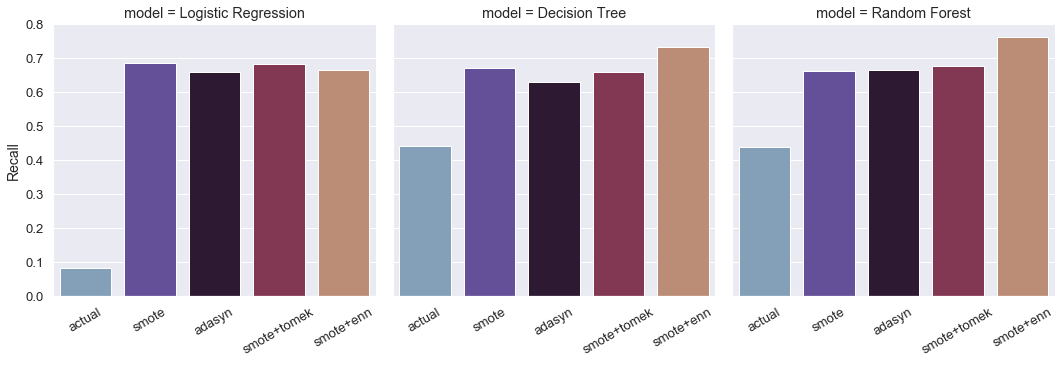

In [55]:
sns.set(font_scale=1.2)
#sns.palplot(sns.color_palette())
g = sns.FacetGrid(clf_eval_df, col="model", height=5)
g.map(sns.barplot, "resample", "recall", palette='twilight', order=["actual", "smote", "adasyn", "smote+tomek", "smote+enn"])
g.set_xticklabels(rotation=30)
g.set_xlabels(' ', fontsize=14)
g.set_ylabels('Recall', fontsize=14)